In [1]:
%load_ext autoreload

In [2]:
import scanpy as sc
import anndata as ad
import scirpy as ir

import pandas as pd
import numpy as np
from tqdm import tqdm

C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%autoreload 2
import sys
sys.path.append('..')

import utils.annotation as utils_annotation

In [4]:
path_results = '../../results/dextramer/CD8'
path_data = '../../data/dextramer/02_dex_annotated_cd8.h5ad'

In [5]:
adata = sc.read(path_data)

In [6]:
binding_mode = 'binding_ct'
time_order = ['P1', 'S1', 'S2', 'S3', 'T1', 'T2', 'T3', 'X3', 'extra']

## Public Clonotypes

In [7]:
cts_public = adata[(adata.obs[binding_mode]!='No binding')
                  & (adata.obs['clone_id']!='nan')
                  ].obs.groupby('clone_id')['donor'].nunique()
cts_public = cts_public[cts_public>1]
adata[adata.obs['clone_id'].isin(cts_public.index)].obs.groupby(['clone_id', 'donor'])[binding_mode].value_counts()


clone_id  donor  binding_ct
772.0     A04    LTDEMIAQY      2
          A15    LTDEMIAQY      1
869.0     A08    FLRGRAYGL     93
          A15    FLRGRAYGL     17
          HIM    FLRGRAYGL      1
1650.0    A07    LTDEMIAQY      2
          HIM    LTDEMIAQY     11
2058.0    A07    LTDEMIAQY      1
          HIM    LTDEMIAQY      2
5356.0    A15    LTDEMIAQY      3
          A16    LTDEMIAQY      1
13133.0   A07    RAKFKQLL       1
          HIM    RAKFKQLL       1
13916.0   A07    CTELKLSDY      7
          HIM    CTELKLSDY      1
Name: binding_ct, dtype: int64

## TCR-Scores

In [8]:
df_tmp = adata[((adata.obs[binding_mode]=='LTDEMIAQY') & (adata.obs['donor'].isin(['A04', 'A08', 'A15', 'HIM'])))
              | ((adata.obs[binding_mode]=='YLQPRTFLL') & (adata.obs['donor'].isin(['29'])))].obs

df_tcr = df_tmp.groupby('clone_id')[['TCR_mean', 'TCRC_mean']].mean()

for t in time_order:
    df_t = df_tmp[df_tmp['time']==t]
    df_t = df_t.groupby('clone_id')[['TCR_mean', 'TCRC_mean']].mean()
    df_t.columns = [f'{t}_{el}' for el in df_t.columns]
    df_tcr = pd.concat([df_tcr, df_t], axis=1)
df_tcr.to_csv('../../results/dextramer/CD8/tcr_expression_by_clone.csv')
df_tcr.head()

,TCR_mean,TCRC_mean,P1_TCR_mean,P1_TCRC_mean,S1_TCR_mean,S1_TCRC_mean,S2_TCR_mean,S2_TCRC_mean,S3_TCR_mean,S3_TCRC_mean,T1_TCR_mean,T1_TCRC_mean,T2_TCR_mean,T2_TCRC_mean,T3_TCR_mean,T3_TCRC_mean,X3_TCR_mean,X3_TCRC_mean,extra_TCR_mean,extra_TCRC_mean
clone_id,,,,,,,,,,,,,,,,,,,,
41.0,0.070389,0.183757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.070389,0.183757,NaN,NaN
66.0,0.087506,1.106411,NaN,NaN,NaN,NaN,0.087506,1.106411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99.0,0.072662,0.855012,NaN,NaN,0.074393,1.11253,0.068848,0.712475,NaN,NaN,0.070924,0.823698,NaN,NaN,0.088642,0.990538,NaN,NaN,NaN,NaN
201.0,0.076058,1.272025,NaN,NaN,NaN,NaN,0.076058,1.272025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
219.0,0.068080,1.090982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.068080,1.090982,NaN,NaN


## Cell counts

In [9]:
df_counts = adata.obs.value_counts(['experiment', 'donor', binding_mode]).unstack()
df_counts = df_counts.fillna(0)
df_counts.columns = [el for el in df_counts.columns]
df_counts['Total'] = df_counts.sum(axis=1)
df_counts = df_counts.astype(int)
df_counts = df_counts[['Total', 'No binding', 'CTELKLSDY', 'FLRGRAYGL', 'FPQSAPHGV',
       'KCYGVSPTK', #'KIADYNYKL', 
        'LTDEMIAQY', 'NYNYLYRLF', 'QPYRVVVL', 'QYIKWPWYI', 
        'RAKFKQLL', 'RLQSLQTYV', 'SPRRARSVA', 'VLNDILSRL', 'YLQPRTFLL', 'YTNSFTRGVY']]
df_counts = df_counts.reset_index()
df_counts = df_counts.sort_values(['experiment', 'donor'])
df_counts.to_csv('../../results/dextramer/CD8/counts_specificity_cells.csv')
df_counts.head()

,experiment,donor,Total,No binding,CTELKLSDY,FLRGRAYGL,FPQSAPHGV,KCYGVSPTK,LTDEMIAQY,NYNYLYRLF,QPYRVVVL,QYIKWPWYI,RAKFKQLL,RLQSLQTYV,SPRRARSVA,VLNDILSRL,YLQPRTFLL,YTNSFTRGVY
0,first_experiment,A02,26,25,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,first_experiment,A03,239,181,0,0,0,50,0,0,0,0,0,1,0,0,7,0
2,first_experiment,A04,137,127,0,0,0,0,10,0,0,0,0,0,0,0,0,0
3,first_experiment,A05,135,135,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,first_experiment,A06,146,140,0,0,0,0,0,4,0,1,0,0,1,0,0,0


In [10]:
df_counts = adata.obs.value_counts(['experiment', 'donor', 'time', binding_mode]).unstack()
df_counts = df_counts.fillna(0)
df_counts.columns = [el for el in df_counts.columns]
df_counts['Total'] = df_counts.sum(axis=1)
df_counts = df_counts.astype(int)
df_counts = df_counts[['Total', 'No binding', 'CTELKLSDY', 'FLRGRAYGL', 'FPQSAPHGV',
       'KCYGVSPTK', #'KIADYNYKL', 
                       'LTDEMIAQY', 'NYNYLYRLF', 'QPYRVVVL', 'QYIKWPWYI', 
        'RAKFKQLL', 'RLQSLQTYV', 'SPRRARSVA', 'VLNDILSRL', 'YLQPRTFLL', 'YTNSFTRGVY']]
df_counts = df_counts.reset_index()
df_counts = df_counts.sort_values(['experiment', 'donor', 'time'])
df_counts.to_csv('../../results/dextramer/CD8/counts_specificity_cells_time.csv')
df_counts.head()

,experiment,donor,time,Total,No binding,CTELKLSDY,FLRGRAYGL,FPQSAPHGV,KCYGVSPTK,LTDEMIAQY,NYNYLYRLF,QPYRVVVL,QYIKWPWYI,RAKFKQLL,RLQSLQTYV,SPRRARSVA,VLNDILSRL,YLQPRTFLL,YTNSFTRGVY
0,first_experiment,A02,S2,26,25,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,first_experiment,A03,S2,239,181,0,0,0,50,0,0,0,0,0,1,0,0,7,0
2,first_experiment,A04,S2,137,127,0,0,0,0,10,0,0,0,0,0,0,0,0,0
3,first_experiment,A05,S2,135,135,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,first_experiment,A06,S2,146,140,0,0,0,0,0,4,0,1,0,0,1,0,0,0


## Clones: probability

In [11]:
df_clones = adata.obs[['clone_id', 'clonotype_sequence']].drop_duplicates()
df_clones = df_clones[df_clones['clone_id']!='nan'][['clone_id', 'clonotype_sequence']].reset_index(drop=True)

df_alpha = df_clones['clonotype_sequence'].str.split(' ').str[0]
df_alpha.to_csv(f'{path_results}/olga_alpha_seqs.tsv', sep='\t', index=False, header=False)

df_beta = df_clones['clonotype_sequence'].str.split(' ').str[1]
df_beta.to_csv(f'{path_results}/olga_beta_seqs.tsv', sep='\t', index=False, header=False)

conda activate olga

olga-compute_pgen --humanTRB -i olga_beta_seqs.tsv -o olga_beta_probs.tsv

olga-compute_pgen --humanTRA -i olga_alpha_seqs.tsv -o olga_alpha_probs.tsv

In [12]:
df_beta = pd.read_csv(f'{path_results}/olga_beta_probs.tsv', sep='\t', header=None, names=['CDR3b', 'CDR3b_prob'])
df_alpha = pd.read_csv(f'{path_results}/olga_alpha_probs.tsv', sep='\t', header=None, names=['CDR3a', 'CDR3a_prob'])

df_clones = pd.concat([df_clones, df_alpha, df_beta], axis=1)
df_clones['joint_prob'] = df_clones['CDR3a_prob'] * df_clones['CDR3b_prob']
df_clones.to_csv(f'{path_results}/clone_probability.csv')
df_clones.head(5)

,clone_id,clonotype_sequence,CDR3a,CDR3a_prob,CDR3b,CDR3b_prob,joint_prob
0,0.0,CIAPLIPRVTF CASSHVSPYTEAFF,CIAPLIPRVTF,0.000000e+00,CASSHVSPYTEAFF,1.405704e-10,0.000000e+00
1,1.0,CAVGASFGNEKLTF CASSTIRQGSNTFF,CAVGASFGNEKLTF,9.655826e-08,CASSTIRQGSNTFF,1.428531e-14,1.379364e-21
2,2.0,CAASETGGGADGLTF CASSPGYEQYF,CAASETGGGADGLTF,6.864149e-07,CASSPGYEQYF,4.419747e-06,3.033781e-12
3,4.0,CAVTLLYNQGGKLIF CASSTPGDYTTGNEQFF,CAVTLLYNQGGKLIF,4.755430e-08,CASSTPGDYTTGNEQFF,2.147123e-14,1.021049e-21
4,5.0,CAGHPNDYKLSF CAVLGQRDSGNTIYF,CAGHPNDYKLSF,3.090002e-07,CAVLGQRDSGNTIYF,8.384309e-12,2.590753e-18


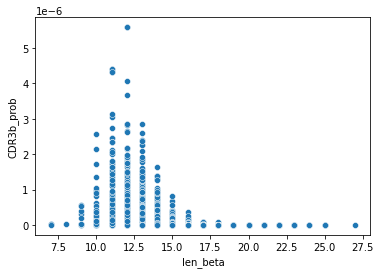

<AxesSubplot:xlabel='len_alpha', ylabel='CDR3a_prob'>

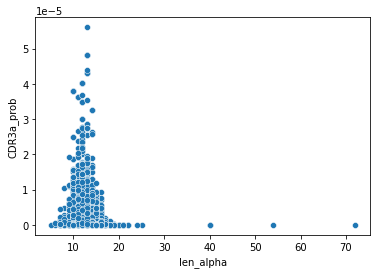

In [13]:
df_clones['len_beta'] = df_clones['CDR3b'].str.len()
df_clones['len_alpha'] = df_clones['CDR3a'].str.len()
import seaborn as sb
import matplotlib.pyplot as plt
sb.scatterplot(data=df_clones, x='len_beta', y='CDR3b_prob')
plt.show()
sb.scatterplot(data=df_clones, x='len_alpha', y='CDR3a_prob')

## Clones: amount of nucleotide sequences

In [14]:
df_full = []
for donor, spec in [('A04', 'LTDEMIAQY'), ('A08', 'LTDEMIAQY'), ('A15', 'LTDEMIAQY'), 
                    ('HIM', 'LTDEMIAQY'), ('A29', 'YLQPRTFLL'), ]:
    adata_tmp = adata[(adata.obs['donor']==donor) & (adata.obs[binding_mode]==spec)]
    df_nuc = adata_tmp.obs[['clone_id', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 
                        'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 
                        'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 
                        'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'clonotype_sequence']]
    df_nuc = df_nuc[df_nuc['clone_id']!='nan']

    def assign_nn_seq(row, chain):
        if row[f'IR_{chain}_1_junction_aa'] in row['clonotype_sequence']:
            return row[f'IR_{chain}_1_junction']
        if str(row[f'IR_{chain}_2_junction_aa']) in row['clonotype_sequence']:
            return row[f'IR_{chain}_2_junction']
        return 'Not present'

    df_nuc['clone_nuc_VJ'] = df_nuc.apply(lambda x: assign_nn_seq(x, 'VJ'), axis=1)
    df_nuc['clone_nuc_VDJ'] = df_nuc.apply(lambda x: assign_nn_seq(x, 'VDJ'), axis=1)
    df_nuc['clone_nuc_VJ+VDJ'] = df_nuc['clone_nuc_VJ'] + '_' + df_nuc['clone_nuc_VDJ']
    df_nuc['clone_id'] = df_nuc['clone_id'].astype(str)

    df_nuc_frac = pd.DataFrame(index=df_nuc['clone_id'].value_counts().index)

    df_nuc_frac= pd.DataFrame(index=df_nuc['clone_id'].value_counts().index)
    for chain in ['VJ', 'VDJ', 'VJ+VDJ']: 
        mapper_ct_frac = df_nuc.groupby('clone_id')[f'clone_nuc_{chain}'].value_counts(normalize=True)
        mapper_ct_frac = pd.DataFrame(mapper_ct_frac)
        mapper_ct_frac.columns = [f'fract_top_{chain}']
        mapper_ct_frac.index = [el[0] for el in mapper_ct_frac.index]
        mapper_ct_frac = mapper_ct_frac[~mapper_ct_frac.index.duplicated(keep='first')]


        df_n = pd.DataFrame(df_nuc.groupby('clone_id')[f'clone_nuc_{chain}'].nunique())
        df_n.index.name = None
        df_n.columns = [f'n_unique_{chain}']

        df_nuc_frac = pd.concat([df_nuc_frac, mapper_ct_frac, df_n], axis=1)

        ct_has_na = df_nuc[df_nuc[f'clone_nuc_VJ+VDJ'].str.contains('Not present')]['clone_id'].unique()
        df_nuc_frac[f'has_otherAA_{chain}'] = df_nuc_frac.index.isin(ct_has_na)

    df_nuc_frac['donor'] = donor
    df_nuc_frac[binding_mode] = spec
    df_nuc_frac.index.name = 'clone_id'
    df_nuc_frac = df_nuc_frac.reset_index()
    df_full.append(df_nuc_frac)
df_full = pd.concat(df_full)
df_full = df_full.reset_index(drop=True)
df_full.to_csv(f'{path_results}/clone_fraction_nucleotides.csv')
df_full.head(5)

,clone_id,fract_top_VJ,n_unique_VJ,has_otherAA_VJ,fract_top_VDJ,n_unique_VDJ,has_otherAA_VDJ,fract_top_VJ+VDJ,n_unique_VJ+VDJ,has_otherAA_VJ+VDJ,donor,binding_ct
0,99.0,1.0,1,False,1.0,1,False,1.0,1,False,A04,LTDEMIAQY
1,5918.0,1.0,1,False,1.0,1,False,1.0,1,False,A04,LTDEMIAQY
2,718.0,1.0,1,False,1.0,1,False,1.0,1,False,A04,LTDEMIAQY
3,832.0,1.0,1,False,1.0,1,False,1.0,1,False,A04,LTDEMIAQY
4,6012.0,1.0,1,False,1.0,1,False,1.0,1,False,A04,LTDEMIAQY


## Dex+ clones by donor

In [15]:
adata_tmp = adata[adata.obs['clone_id']!='nan']
adata_tmp = adata_tmp[adata_tmp.obs[binding_mode]!='No binding']
content = pd.DataFrame(adata_tmp.obs.groupby(['donor', 'time', binding_mode])['clone_id'].nunique())
content = content.reset_index()
content = content.pivot_table(index='donor', columns=['time', binding_mode], values='clone_id')
content.columns = [f'{col[0]}_{col[1]}' if isinstance(col, tuple) else col for col in content.columns]
content.head(3)

,P1_CTELKLSDY,P1_FLRGRAYGL,P1_FPQSAPHGV,P1_KCYGVSPTK,P1_LTDEMIAQY,P1_NYNYLYRLF,P1_QPYRVVVL,P1_QYIKWPWYI,P1_RAKFKQLL,P1_RLQSLQTYV,...,extra_LTDEMIAQY,extra_NYNYLYRLF,extra_QPYRVVVL,extra_QYIKWPWYI,extra_RAKFKQLL,extra_RLQSLQTYV,extra_SPRRARSVA,extra_VLNDILSRL,extra_YLQPRTFLL,extra_YTNSFTRGVY
donor,,,,,,,,,,,,,,,,,,,,,
A02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
content2 = pd.DataFrame(adata_tmp.obs.groupby(['donor', binding_mode])['clone_id'].nunique())
content2 = content2.reset_index()
content2 = content2.pivot_table(index='donor', columns=[binding_mode], values='clone_id')
content2.columns.names = [None]
content2.head(3)

,CTELKLSDY,FLRGRAYGL,FPQSAPHGV,KCYGVSPTK,LTDEMIAQY,NYNYLYRLF,QPYRVVVL,QYIKWPWYI,RAKFKQLL,RLQSLQTYV,SPRRARSVA,VLNDILSRL,YLQPRTFLL,YTNSFTRGVY
donor,,,,,,,,,,,,,,
A02,0,0,0,0,0,0,0,1,0,0,0,0,0,0
A03,0,0,0,32,0,0,0,0,0,1,0,0,6,0
A04,0,0,8,0,22,0,0,0,0,0,20,0,0,2


In [17]:
content3 = pd.DataFrame(adata_tmp.obs.groupby(['donor'])['clone_id'].nunique())
content3.columns = ['#Dex+CTs']
content3.head(3)

,#Dex+CTs
donor,
A02,1
A03,39
A04,52


In [18]:
content4 = pd.DataFrame(adata.obs.groupby(['donor'])['clone_id'].nunique())
content4.columns = ['#CD8-CTs']
content4.head(3)

,#CD8-CTs
donor,
A02,21
A03,161
A04,1659


In [19]:
content5 = pd.DataFrame(adata.obs.groupby(['donor', 'time'])['clone_id'].nunique())
content5 = content5.reset_index()
content5 = content5.pivot_table(index='donor', columns=['time'], values='clone_id')
content5.columns = [f'#CD8-CTs_{t}' for t in content5.columns]
content5.head(3)

,#CD8-CTs_P1,#CD8-CTs_S1,#CD8-CTs_S2,#CD8-CTs_S3,#CD8-CTs_T1,#CD8-CTs_T2,#CD8-CTs_T3,#CD8-CTs_X3,#CD8-CTs_extra
donor,,,,,,,,,
A02,0,0,21,0,0,0,0,0,0
A03,0,0,161,0,0,0,0,0,0
A04,352,263,66,342,604,139,369,0,0


In [20]:
content6 = pd.DataFrame(adata_tmp.obs.groupby(['donor', 'time'])['clone_id'].nunique())
content6 = content6.reset_index()
content6 = content6.pivot_table(index='donor', columns=['time'], values='clone_id')
content6.columns = [f'#Dex+-CTs_{t}' for t in content6.columns]
content6.head(3)

,#Dex+-CTs_P1,#Dex+-CTs_S1,#Dex+-CTs_S2,#Dex+-CTs_S3,#Dex+-CTs_T1,#Dex+-CTs_T2,#Dex+-CTs_T3,#Dex+-CTs_X3,#Dex+-CTs_extra
donor,,,,,,,,,
A02,0,0,1,0,0,0,0,0,0
A03,0,0,39,0,0,0,0,0,0
A04,3,11,9,6,33,13,10,0,0


In [21]:
content_full = pd.concat([content4, content5, content3, content6, content2, content], axis=1)
content_full.to_csv(f'{path_results}/clonotype_counts_specificity.csv')
content_full.head(3)

,#CD8-CTs,#CD8-CTs_P1,#CD8-CTs_S1,#CD8-CTs_S2,#CD8-CTs_S3,#CD8-CTs_T1,#CD8-CTs_T2,#CD8-CTs_T3,#CD8-CTs_X3,#CD8-CTs_extra,...,extra_LTDEMIAQY,extra_NYNYLYRLF,extra_QPYRVVVL,extra_QYIKWPWYI,extra_RAKFKQLL,extra_RLQSLQTYV,extra_SPRRARSVA,extra_VLNDILSRL,extra_YLQPRTFLL,extra_YTNSFTRGVY
donor,,,,,,,,,,,,,,,,,,,,,
A02,21,0,0,21,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A03,161,0,0,161,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A04,1659,352,263,66,342,604,139,369,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
content_full.columns.tolist()

['#CD8-CTs',
 '#CD8-CTs_P1',
 '#CD8-CTs_S1',
 '#CD8-CTs_S2',
 '#CD8-CTs_S3',
 '#CD8-CTs_T1',
 '#CD8-CTs_T2',
 '#CD8-CTs_T3',
 '#CD8-CTs_X3',
 '#CD8-CTs_extra',
 '#Dex+CTs',
 '#Dex+-CTs_P1',
 '#Dex+-CTs_S1',
 '#Dex+-CTs_S2',
 '#Dex+-CTs_S3',
 '#Dex+-CTs_T1',
 '#Dex+-CTs_T2',
 '#Dex+-CTs_T3',
 '#Dex+-CTs_X3',
 '#Dex+-CTs_extra',
 'CTELKLSDY',
 'FLRGRAYGL',
 'FPQSAPHGV',
 'KCYGVSPTK',
 'LTDEMIAQY',
 'NYNYLYRLF',
 'QPYRVVVL',
 'QYIKWPWYI',
 'RAKFKQLL',
 'RLQSLQTYV',
 'SPRRARSVA',
 'VLNDILSRL',
 'YLQPRTFLL',
 'YTNSFTRGVY',
 'P1_CTELKLSDY',
 'P1_FLRGRAYGL',
 'P1_FPQSAPHGV',
 'P1_KCYGVSPTK',
 'P1_LTDEMIAQY',
 'P1_NYNYLYRLF',
 'P1_QPYRVVVL',
 'P1_QYIKWPWYI',
 'P1_RAKFKQLL',
 'P1_RLQSLQTYV',
 'P1_SPRRARSVA',
 'P1_VLNDILSRL',
 'P1_YLQPRTFLL',
 'P1_YTNSFTRGVY',
 'S1_CTELKLSDY',
 'S1_FLRGRAYGL',
 'S1_FPQSAPHGV',
 'S1_KCYGVSPTK',
 'S1_LTDEMIAQY',
 'S1_NYNYLYRLF',
 'S1_QPYRVVVL',
 'S1_QYIKWPWYI',
 'S1_RAKFKQLL',
 'S1_RLQSLQTYV',
 'S1_SPRRARSVA',
 'S1_VLNDILSRL',
 'S1_YLQPRTFLL',
 'S1_YTNSFTRGVY',
 '

In [23]:
tmp = adata[adata.obs['binding_ct']=='LTDEMIAQY'].obs.groupby('clone_id')['donor'].nunique()
tmp.sort_values(ascending=False)

clone_id
772.0      2
1650.0     2
2058.0     2
5356.0     2
11403.0    1
          ..
5170.0     1
4545.0     1
4386.0     1
4350.0     1
20205.0    1
Name: donor, Length: 131, dtype: int64

## Cells of specific CTS over time points

In [24]:
ltd_clones = adata[adata.obs['donor'].isin(['A04', 'A08', 'A15', 'A16']) &
                      (adata.obs[binding_mode] == 'LTDEMIAQY')].obs['clone_id'].unique().tolist()
if 'nan' in ltd_clones:
    ltd_clones.remove('nan')

In [25]:
ylq_clones = adata[adata.obs['donor'].isin(['A29']) &
                      (adata.obs[binding_mode] == 'YLQPRTFLL')].obs['clone_id'].unique().tolist()
if 'nan' in ylq_clones:
    ylq_clones.remove('nan')

In [26]:
adata_tmp = adata[(adata.obs['clone_id'].isin(ltd_clones) & adata.obs['donor'].isin(['A04', 'A08', 'A15', 'A16'])) |
                (adata.obs['clone_id'].isin(ylq_clones) & adata.obs['donor'].isin(['A29']))]

In [27]:
cell_content = pd.DataFrame(adata_tmp.obs.groupby(['donor', 'time'])['clone_id'].value_counts())
cell_content.columns = ['#Cells']
cell_content = cell_content.reset_index()
cell_content = cell_content.pivot_table(index=['donor', 'clone_id'], columns=['time'], values='#Cells')
cell_content = cell_content.fillna(0)
cell_content.to_csv(f'{path_results}/selected_ct_cell_counts.csv')
cell_content

time             P1   S1   S2   S3   T1   T2   T3
donor clone_id                                   
A04   99.0      0.0  1.0  1.0  0.0  8.0  0.0  1.0
      201.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
      225.0     0.0  1.0  1.0  0.0  1.0  0.0  0.0
      297.0     0.0  1.0  2.0  1.0  1.0  0.0  1.0
      646.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
...             ...  ...  ...  ...  ...  ...  ...
A29   9825.0    0.0  0.0  0.0  1.0  0.0  0.0  0.0
      9961.0    0.0  0.0  0.0  1.0  1.0  0.0  0.0
      9973.0    0.0  0.0  0.0  1.0  0.0  0.0  0.0
      10749.0   0.0  0.0  0.0  0.0  1.0  0.0  0.0
      11445.0   0.0  0.0  0.0  0.0  1.0  0.0  0.0

[131 rows x 7 columns]

## DEGs

In [28]:
dict_deg = {}
for cluster in adata.obs['leiden_CD8'].unique():
    names = adata.uns['rank_genes_groups_CD8']['names'][cluster].tolist()
    scores = adata.uns['rank_genes_groups_CD8']['scores'][cluster].tolist()
    dict_deg[cluster] = list(zip(names, scores))
    
df_degs = pd.DataFrame(dict_deg)
df_degs = df_degs[sorted(df_degs.columns.tolist())]
df_degs.columns = [f'leiden_CD8_{el}' for el in df_degs.columns]
df_degs.to_csv('../../results/dextramer/CD8/CD8_deg_gex_by_leiden_cluster.csv')

In [29]:
dict_deg = {}
for cluster in adata.obs['leiden_CD8'].unique():
    if cluster in ['10', '12']:
        continue
    names = adata.uns['rank_genes_groups_leiden_cite']['names'][cluster].tolist()
    scores = adata.uns['rank_genes_groups_leiden_cite']['scores'][cluster].tolist()
    dict_deg[cluster] = list(zip(names, scores))
        
df_degs = pd.DataFrame(dict_deg)
df_degs = df_degs[sorted(df_degs.columns.tolist())]
df_degs.columns = [f'leiden_CD8_{el}' for el in df_degs.columns]
df_degs.to_csv('../../results/dextramer/CD8/CD8_deg_cite_by_leiden_cluster.csv')

## Clone counts

In [30]:
df_tmp = adata.obs.copy()
df_tmp = df_tmp[df_tmp['donor'].isin(['A04', 'A08', 'A15', 'HIM']) & (df_tmp[binding_mode]=='LTDEMIAQY')]
df_tmp = df_tmp[df_tmp['clone_id']!='nan']
df_tmp['time'] = df_tmp['time'].astype(str).replace({'nan': 'HIM'})
df_tmp = pd.DataFrame(df_tmp.groupby(['donor', 'time'])['clone_id'].value_counts())
df_tmp.columns = ['#Cells']
df_tmp = df_tmp.reset_index()
df_tmp.to_csv('../../results/dextramer/CD8/cellcounts_LTD_clones_selected_donors.csv')

In [31]:
df_tmp[df_tmp['clone_id']=='1650.0']

,donor,time,clone_id,#Cells
180,HIM,X3,1650.0,11


In [32]:
adata[adata.obs['clone_id']=='2058.0'].obs[['donor', 'time', 'clone_id', 'experiment', binding_mode]]

,donor,time,clone_id,experiment,binding_ct
CCCAATCTCAACACCA-1-0-1,HIM,X3,2058.0,third_experiment,LTDEMIAQY
CTACATTTCGTTTATC-1-0-1,HIM,X3,2058.0,third_experiment,LTDEMIAQY
TCTATTGCAGATGAGC-1-0-1,A07,T3,2058.0,third_experiment,LTDEMIAQY


In [33]:
df_tmp = adata.obs.copy()
df_tmp = df_tmp[df_tmp['donor'].isin(['A29']) & (df_tmp[binding_mode]=='YLQPRTFLL')]
df_tmp = df_tmp[df_tmp['clone_id']!='nan']
df_tmp = pd.DataFrame(df_tmp.groupby(['donor', 'time'])['clone_id'].value_counts())
df_tmp.columns = ['#Cells']
df_tmp = df_tmp.reset_index()
df_tmp.to_csv('../../results/dextramer/CD8/cellcounts_YLQ_clones_selected_donors.csv')

In [34]:
df_tmp

,donor,time,clone_id,#Cells
0,A29,P1,3695.0,1
1,A29,S1,6140.0,2
2,A29,S1,323.0,1
3,A29,S1,691.0,1
4,A29,S1,3695.0,1
5,A29,S1,5766.0,1
6,A29,S1,6467.0,1
7,A29,S1,6579.0,1
8,A29,S1,6688.0,1
9,A29,S1,7411.0,1


In [35]:
df_tmp['time'].value_counts()

S1       9
S3       7
T1       4
S2       3
P1       1
T2       0
T3       0
X3       0
extra    0
Name: time, dtype: int64

## LTD/YLQ clones in specific clusters

In [36]:
df_tmp = adata[adata.obs[binding_mode].isin(['LTDEMIAQY', 'YLQPRTFLL'])].obs
df_tmp = df_tmp.groupby('clone_id')['leiden_CD8'].value_counts()
df_tmp = df_tmp.unstack().fillna(0)
cts_cluster5 = df_tmp[df_tmp['5']==df_tmp.sum(axis=1)].index.tolist()
df_c5 = adata[adata.obs['clone_id'].isin(cts_cluster5)].obs
df_c5 = df_c5[['clone_id', 'clone_size', 'donor', 'binding_ct', 'leiden_CD8']].reset_index(drop=True)
df_c5 = pd.DataFrame(df_c5.value_counts())
df_c5.columns = ['#Cells']
df_c5 = df_c5.reset_index().sort_values('clone_id').reset_index(drop=True)
df_c5.to_csv('../../results/dextramer/CD8/amountCellsCluster_onlyCluster5.csv')
df_c5

,clone_id,clone_size,donor,binding_ct,leiden_CD8,#Cells
0,8191.0,1.0,A29,YLQPRTFLL,5,1
1,9973.0,1.0,A29,YLQPRTFLL,5,1
2,11964.0,1.0,A15,LTDEMIAQY,5,1
3,15599.0,1.0,A07,LTDEMIAQY,5,1
4,17674.0,1.0,A15,LTDEMIAQY,5,1
5,18755.0,1.0,A16,LTDEMIAQY,5,1
6,19327.0,1.0,A16,LTDEMIAQY,5,1
7,20205.0,1.0,A08,LTDEMIAQY,5,1


In [37]:
df_c5_info = adata[adata.obs['clone_id'].isin(df_c5['clone_id'])].obs
df_c5_info = df_c5_info[['clone_id', 'clone_size', 'donor', 'binding_ct', 'leiden_CD8', 
                         'clonotype_sequence', 'j_genes', 'v_genes',
               'IR_VJ_1_j_call', 'IR_VJ_1_v_call',
               'IR_VDJ_1_j_call', 'IR_VDJ_1_v_call',
               'IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa',
               'IR_VJ_1_junction', 'IR_VDJ_1_junction',
               'IR_VJ_2_j_call', 'IR_VJ_2_v_call',
               'IR_VDJ_2_j_call', 'IR_VDJ_2_v_call',
               'IR_VJ_2_junction_aa', 'IR_VDJ_2_junction_aa',
               'IR_VJ_2_junction', 'IR_VDJ_2_junction',]].reset_index(drop=True)
df_c5_info.to_csv('../../results/dextramer/CD8/clonotypeInfo_onlyCluster5.csv')
df_c5_info

,clone_id,clone_size,donor,binding_ct,leiden_CD8,clonotype_sequence,j_genes,v_genes,IR_VJ_1_j_call,IR_VJ_1_v_call,...,IR_VJ_1_junction,IR_VDJ_1_junction,IR_VJ_2_j_call,IR_VJ_2_v_call,IR_VDJ_2_j_call,IR_VDJ_2_v_call,IR_VJ_2_junction_aa,IR_VDJ_2_junction_aa,IR_VJ_2_junction,IR_VDJ_2_junction
0,8191.0,1.0,A29,YLQPRTFLL,5,CAEMMDSSYKLIF CASSPGLSYEQYF,TRAJ12 TRBJ2-7,TRAV5 TRBV3-1,TRAJ12,TRAV5,...,TGTGCAGAGATGATGGATAGCAGCTATAAATTGATCTTC,TGTGCCAGCAGCCCCGGACTCTCCTACGAGCAGTACTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9973.0,1.0,A29,YLQPRTFLL,5,CAVDSSFQGAQKLVF CASSLPDSYEQYF,TRAJ54 TRBJ2-7,TRAV39 TRBV6-2,TRAJ54,TRAV39,...,TGTGCCGTGGACAGCTCCTTTCAGGGAGCCCAGAAGCTGGTATTT,TGTGCCAGCAGTCTACCCGACAGTTACGAGCAGTACTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11964.0,1.0,A15,LTDEMIAQY,5,CAVRYSNTGKLIF CASSQEQTGGYTF,TRAJ37 TRBJ1-2,TRAV1-2 TRBV14,TRAJ37,TRAV1-2,...,TGTGCTGTGAGATATAGCAACACAGGCAAACTAATCTTT,TGTGCCAGCAGCCAAGAGCAGACGGGTGGCTACACCTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15599.0,1.0,A07,LTDEMIAQY,5,CALGAGSYQLTF CASSQLSGGRPGELFF,TRAJ28 TRBJ2-2,TRAV38-1 TRBV3-1,TRAJ28,TRAV38-1,...,TGTGCGCTTGGGGCTGGGAGTTACCAACTCACTTTC,TGTGCCAGCAGCCAGCTGAGCGGGGGAAGGCCCGGGGAGCTGTTTTTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17674.0,1.0,A15,LTDEMIAQY,5,CAAILLTGGGNKLTF CSARDLSGPAGETQYF,TRAJ10 TRBJ2-5,TRAV13-1 TRBV20-1,TRAJ10,TRAV13-1,...,TGTGCAGCAATTTTACTCACGGGAGGAGGAAACAAACTCACCTTT,TGCAGTGCTAGAGATCTCAGCGGCCCCGCAGGAGAGACCCAGTACTTC,TRAJ4,TRAV17,TRBJ2-1,TRBV27,CAIPAFSGGYNKLIF,CASSGGLHNEQFF,TGTGCTATCCCGGCCTTTTCTGGTGGCTACAATAAGCTGATTTTT,TGTGCCAGCAGTGGGGGACTCCACAATGAGCAGTTCTTC
5,18755.0,1.0,A16,LTDEMIAQY,5,CIVRQLDYNQGGKLIF CASSLELGLTDTQYF,TRAJ23 TRBJ2-3,TRAV26-1 TRBV5-4,TRAJ23,TRAV26-1,...,TGCATCGTCAGACAACTCGATTATAACCAGGGAGGAAAGCTTATCTTC,TGTGCCAGCAGCTTGGAGTTGGGGTTGACAGATACGCAGTATTTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,19327.0,1.0,A16,LTDEMIAQY,5,CAATQGGSEKLVF CASSSTSSYNEQFF,TRAJ57 TRBJ2-1,TRAV21 TRBV5-4,TRAJ57,TRAV21,...,TGTGCTGCCACTCAGGGCGGATCTGAAAAGCTGGTCTTT,TGTGCCAGCAGCTCAACCTCCTCCTACAATGAGCAGTTCTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,20205.0,1.0,A08,LTDEMIAQY,5,CAGPYNNAGNMLTF CASSLSRGFPYEQYF,TRAJ39 TRBJ2-7,TRAV25 TRBV27,TRAJ39,TRAV25,...,TGTGCAGGCCCTTATAATAATGCAGGCAACATGCTCACCTTT,TGTGCCAGCAGTTTATCGCGGGGCTTCCCCTACGAGCAGTACTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
cts_cluster8wo5 = df_tmp[(df_tmp['5']==0) & (df_tmp['8']>0)].index.tolist()
df_8wo5 = adata[adata.obs['clone_id'].isin(cts_cluster8wo5)].obs
df_8wo5 = df_8wo5[['clone_id', 'clone_size', 'donor', 'binding_ct', 'leiden_CD8']].reset_index(drop=True)
df_8wo5 = pd.DataFrame(df_8wo5.value_counts())
df_8wo5.columns = ['#Cells']
df_8wo5 = df_8wo5.reset_index().sort_values(['clone_id', 'leiden_CD8']).reset_index(drop=True)
df_8wo5.to_csv('../../results/dextramer/CD8/amountCellsCluster_cluster8not5.csv')
df_8wo5.head(20)

,clone_id,clone_size,donor,binding_ct,leiden_CD8,#Cells
0,28.0,2.0,A11,YLQPRTFLL,1,1
1,28.0,1.0,A11,YLQPRTFLL,3,1
2,28.0,2.0,A11,YLQPRTFLL,3,1
3,28.0,1.0,A11,YLQPRTFLL,8,1
4,99.0,1.0,A04,LTDEMIAQY,3,1
5,99.0,1.0,A04,LTDEMIAQY,4,1
6,99.0,8.0,A04,LTDEMIAQY,8,8
7,99.0,1.0,A04,LTDEMIAQY,8,1
8,225.0,1.0,A04,LTDEMIAQY,3,2
9,225.0,1.0,A04,LTDEMIAQY,8,1


In [39]:
df_8wo5_info = adata[adata.obs['clone_id'].isin(df_8wo5['clone_id'])].obs
df_8wo5_info = df_8wo5_info[['clone_id', 'clone_size', 'donor', 
               'clonotype_sequence', 'j_genes', 'v_genes',
               'IR_VJ_1_j_call', 'IR_VJ_1_v_call',
               'IR_VDJ_1_j_call', 'IR_VDJ_1_v_call',
               'IR_VJ_1_junction_aa', 'IR_VDJ_1_junction_aa',
               'IR_VJ_1_junction', 'IR_VDJ_1_junction',
               'IR_VJ_2_j_call', 'IR_VJ_2_v_call',
               'IR_VDJ_2_j_call', 'IR_VDJ_2_v_call',
               'IR_VJ_2_junction_aa', 'IR_VDJ_2_junction_aa',
               'IR_VJ_2_junction', 'IR_VDJ_2_junction',]].drop_duplicates().reset_index(drop=True)
df_8wo5_info.to_csv('../../results/dextramer/CD8/clonotypeInfo_cluster8not5.csv')
df_8wo5_info

,clone_id,clone_size,donor,clonotype_sequence,j_genes,v_genes,IR_VJ_1_j_call,IR_VJ_1_v_call,IR_VDJ_1_j_call,IR_VDJ_1_v_call,...,IR_VJ_1_junction,IR_VDJ_1_junction,IR_VJ_2_j_call,IR_VJ_2_v_call,IR_VDJ_2_j_call,IR_VDJ_2_v_call,IR_VJ_2_junction_aa,IR_VDJ_2_junction_aa,IR_VJ_2_junction,IR_VDJ_2_junction
0,28.0,2.0,A11,CAVNIDDKIIF CASSPDIEQFF,TRAJ30 TRBJ2-1,TRAV12-2 TRBV7-9,TRAJ30,TRAV12-2,TRBJ2-1,TRBV7-9,...,TGTGCCGTGAACATAGATGACAAGATCATCTTT,TGTGCCAGCAGCCCGGACATTGAGCAGTTCTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,99.0,1.0,A04,CAERRGKLQF CATSRGPGGSKAGETQYF,TRAJ24 TRBJ2-5,TRAV5 TRBV15,TRAJ24,TRAV5,TRBJ2-5,TRBV15,...,TGTGCAGAGAGGAGGGGGAAATTGCAGTTT,TGTGCCACCAGCAGGGGCCCTGGGGGGAGTAAAGCGGGGGAGACCC...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,225.0,1.0,A04,CAVGNSGYALNF CASLEGPGNEQFF,TRAJ41 TRBJ2-1,TRAV12-2 TRBV11-2,TRAJ41,TRAV12-2,TRBJ2-1,TRBV11-2,...,TGTGCCGTGGGAAATTCCGGGTATGCACTCAACTTC,TGTGCCAGCCTCGAGGGCCCGGGGAATGAGCAGTTCTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,297.0,2.0,A04,CALKGVNRDDKIIF CSVFTGWPYEQYF,TRAJ30 TRBJ2-7,TRAV16 TRBV29-1,TRAJ30,TRAV16,TRBJ2-7,TRBV29-1,...,TGTGCTCTAAAAGGGGTGAACAGAGATGACAAGATCATCTTT,TGCAGCGTTTTCACAGGGTGGCCCTACGAGCAGTACTTC,TRAJ33,TRAV12-2,NaN,NaN,CAVSQGGVSNYQLIW,NaN,TGTGCCGTGTCCCAGGGGGGCGTAAGCAACTATCAGTTAATCTGG,NaN
4,323.0,1.0,A29,CVVNRDNDMRF CASQDANTGELFF,TRAJ43 TRBJ2-2,TRAV12-1 TRBV19,TRAJ43,TRAV12-1,TRBJ2-2,TRBV19,...,TGTGTGGTGAACAGAGACAATGACATGCGCTTT,TGTGCCAGTCAGGACGCGAACACCGGGGAGCTGTTTTTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,19695.0,1.0,A08,CAGYRAGTYKYIF CASTSHPTVSSYNEQFF,TRAJ40 TRBJ2-1,TRAV25 TRBV28,TRAJ40,TRAV25,TRBJ2-1,TRBV28,...,TGTGCAGGGTATCGGGCAGGAACCTACAAATACATCTTT,TGTGCCAGCACCTCCCACCCGACAGTATCCTCCTACAATGAGCAGT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
148,5251.0,2.0,A08,CAVNGGGGSNYKLTF CSVGTGWPYEQYF,TRAJ53 TRBJ2-7,TRAV12-2 TRBV29-1,TRAJ53,TRAV12-2,TRBJ2-7,TRBV29-1,...,TGTGCCGTGAACGGGGGTGGAGGTAGCAACTATAAACTGACATTT,TGCAGCGTCGGGACAGGGTGGCCCTACGAGCAGTACTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149,11251.0,1.0,A08,CALRRGYNKLIF CASLSGSGNTIYF,TRAJ4 TRBJ1-3,TRAV19 TRBV6-6,TRAJ4,TRAV19,TRBJ1-3,TRBV6-6,...,TGTGCTCTGAGGAGGGGCTACAATAAGCTGATTTTT,TGTGCCAGCCTGTCTGGCTCTGGAAACACCATATATTTT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150,5251.0,1.0,A08,CAVNGGGGSNYKLTF CSVGTGWPYEQYF,TRAJ53 TRBJ2-7,TRAV12-2 TRBV29-1,TRAJ53,TRAV12-2,TRBJ2-7,TRBV29-1,...,TGTGCCGTGAACGGGGGTGGAGGTAGCAACTATAAACTGACATTT,TGCAGCGTCGGGACAGGGTGGCCCTACGAGCAGTACTTC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Mean Dex count

In [40]:
df_tmp = adata[adata.obs['clone_id'].notna()
              & (adata.obs['clone_id']!='nan')].obs.copy()
for col in ['clone_id', 'time', 'experiment']:
    df_tmp[col] = df_tmp[col].astype(str)
df_tmp = df_tmp[['clone_id', 'time', 'experiment'] + adata.uns['epitopes'].tolist()]
df_tmp = df_tmp.groupby(['clone_id', 'time', 'experiment']).mean()
#df_tmp = df_tmp.reset_index()
df_tmp.to_csv('../../results/dextramer/CD8/mean_dextra_counts_CloneTimeExperiment.csv')
df_tmp.head()

LTDEMIAQY  YTNSFTRGVY  YLQPRTFLL  RLQSLQTYV  \
clone_id time experiment                                                       
0.0      S2   first_experiment         0.0         0.0        0.0        0.0   
1.0      S2   first_experiment         0.0         1.0        0.0        0.0   
10.0     S2   first_experiment         0.0         0.0        0.0        0.0   
         S3   second_experiment        0.0         0.0        0.0        1.0   
         T1   second_experiment        0.0         0.0        0.0        0.0   

                                 VLNDILSRL  KIADYNYKL  KCYGVSPTK  KVFRSSVLH  \
clone_id time experiment                                                      
0.0      S2   first_experiment         0.0        0.0        0.0        0.0   
1.0      S2   first_experiment         0.0        0.0        0.0        0.0   
10.0     S2   first_experiment         0.0        0.0       14.0        1.0   
         S3   second_experiment        0.0        0.0        1.0        1.0   
         T1   second_experiment        0.0        0.0        0.0        0.0   

                                 RLFRKSNLK  GTHWFVTQR  ...  NYNYLYRLF  \
clone_id time experiment                               ...              
0.0      S2   first_experiment         3.0        0.0  ...        0.0   
1.0      S2   first_experiment         0.0        0.0  ...        0.0   
10.0     S2   first_experiment        17.0       14.0  ...        0.0   
         S3   second_experiment        2.0        0.0  ...        1.0   
         T1   second_experiment        2.0        0.0  ...        0.0   

                                 SPRRARSVA  FPQSAPHGV  QPYRVVVL  IYKTPPIKDF  \
clone_id time experiment                                                      
0.0      S2   first_experiment         0.0        0.0       0.0         0.0   
1.0      S2   first_experiment         0.0        0.0       0.0         0.0   
10.0     S2   first_experiment         0.0        0.0       0.0         0.0   
         S3   second_experiment        0.0        0.0       0.0         0.0   
         T1   second_experiment        0.0        0.0       0.0         0.0   

                                 TFEYVSQPFLMDLE  ATDSLNNEY  CTELKLSDY  \
clone_id time experiment                                                
0.0      S2   first_experiment              NaN        NaN        NaN   
1.0      S2   first_experiment              NaN        NaN        NaN   
10.0     S2   first_experiment              NaN        NaN        NaN   
         S3   second_experiment             NaN        NaN        NaN   
         T1   second_experiment             NaN        NaN        NaN   

                                 FLRGRAYGL  RAKFKQLL  
clone_id time experiment                              
0.0      S2   first_experiment         NaN       NaN  
1.0      S2   first_experiment         NaN       NaN  
10.0     S2   first_experiment         NaN       NaN  
         S3   second_experiment        NaN       NaN  
         T1   second_experiment        NaN       NaN  

[5 rows x 21 columns]

In [41]:
adata[adata.obs['clone_id']=='0.0'].obs[['time'] + adata.uns['epitopes'].tolist()]

,time,LTDEMIAQY,YTNSFTRGVY,YLQPRTFLL,RLQSLQTYV,VLNDILSRL,KIADYNYKL,KCYGVSPTK,KVFRSSVLH,RLFRKSNLK,...,NYNYLYRLF,SPRRARSVA,FPQSAPHGV,QPYRVVVL,IYKTPPIKDF,TFEYVSQPFLMDLE,ATDSLNNEY,CTELKLSDY,FLRGRAYGL,RAKFKQLL
AAACCTGAGTGTTGAA-1-initial-0-0,S2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [42]:
df_tmp

LTDEMIAQY  YTNSFTRGVY  YLQPRTFLL  RLQSLQTYV  \
clone_id time experiment                                                       
0.0      S2   first_experiment         0.0         0.0        0.0        0.0   
1.0      S2   first_experiment         0.0         1.0        0.0        0.0   
10.0     S2   first_experiment         0.0         0.0        0.0        0.0   
         S3   second_experiment        0.0         0.0        0.0        1.0   
         T1   second_experiment        0.0         0.0        0.0        0.0   
...                                    ...         ...        ...        ...   
9991.0   S3   second_experiment        2.0         0.0        0.0        0.0   
9992.0   S3   second_experiment        0.0         0.0        0.0        0.0   
9993.0   S3   second_experiment        0.0         0.0        0.0        0.0   
9996.0   S3   second_experiment        0.0         0.0        0.0        0.0   
9999.0   S3   second_experiment        0.0         0.0        0.0        0.0   

                                 VLNDILSRL  KIADYNYKL  KCYGVSPTK  KVFRSSVLH  \
clone_id time experiment                                                      
0.0      S2   first_experiment         0.0        0.0        0.0        0.0   
1.0      S2   first_experiment         0.0        0.0        0.0        0.0   
10.0     S2   first_experiment         0.0        0.0       14.0        1.0   
         S3   second_experiment        0.0        0.0        1.0        1.0   
         T1   second_experiment        0.0        0.0        0.0        0.0   
...                                    ...        ...        ...        ...   
9991.0   S3   second_experiment        0.0        0.0        7.0        0.0   
9992.0   S3   second_experiment        0.0        0.0        2.0        1.0   
9993.0   S3   second_experiment        0.0        0.0        1.0        1.0   
9996.0   S3   second_experiment        0.0        0.0        0.0        0.0   
9999.0   S3   second_experiment        0.0        0.0        1.0        0.0   

                                 RLFRKSNLK  GTHWFVTQR  ...  NYNYLYRLF  \
clone_id time experiment                               ...              
0.0      S2   first_experiment         3.0        0.0  ...        0.0   
1.0      S2   first_experiment         0.0        0.0  ...        0.0   
10.0     S2   first_experiment        17.0       14.0  ...        0.0   
         S3   second_experiment        2.0        0.0  ...        1.0   
         T1   second_experiment        2.0        0.0  ...        0.0   
...                                    ...        ...  ...        ...   
9991.0   S3   second_experiment        4.0        0.0  ...        0.0   
9992.0   S3   second_experiment        2.0        0.0  ...        0.0   
9993.0   S3   second_experiment        2.0        0.0  ...        0.0   
9996.0   S3   second_experiment        0.0        0.0  ...        0.0   
9999.0   S3   second_experiment        0.0        0.0  ...        0.0   

                                 SPRRARSVA  FPQSAPHGV  QPYRVVVL  IYKTPPIKDF  \
clone_id time experiment                                                      
0.0      S2   first_experiment         0.0        0.0       0.0         0.0   
1.0      S2   first_experiment         0.0        0.0       0.0         0.0   
10.0     S2   first_experiment         0.0        0.0       0.0         0.0   
         S3   second_experiment        0.0        0.0       0.0         0.0   
         T1   second_experiment        0.0        0.0       0.0         0.0   
...                                    ...        ...       ...         ...   
9991.0   S3   second_experiment        0.0        0.0       0.0         0.0   
9992.0   S3   second_experiment        0.0        0.0       0.0         0.0   
9993.0   S3   second_experiment        0.0        0.0       0.0         0.0   
9996.0   S3   second_experiment        0.0        0.0       0.0         0.0   
9999.0   S3   second_experiment        0.0        0.0       0.0   